<a href="https://colab.research.google.com/github/intelligenxe/FinRL-type/blob/main/FinRL_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

These codes are based on the codes of the following videos series by linkedin.com/in/everett-minshall/ : <br>
https://www.youtube.com/watch?v=OrqffjqkklM  <br>
https://www.youtube.com/watch?v=uYC3sc5gers <br>
https://www.youtube.com/watch?v=335QxO36pzo&t=15s <br>
The codes in the above videos are in turn based on https://github.com/AI4Finance-Foundation/FinRL-Tutorials/tree/master (FinRL Tutorials).

FinRL allows us to train a basket of stocks

# Install and Import Packages

In [ ]:
# install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
# install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.4 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.24
    Uninstalling SQLAlchemy-2.0.24:
      Successfully uninstalled SQLAlchemy-2.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.51 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.4 MB/s eta 0:00:00
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-78th3yq2
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-78th3yq2
  Resolved ht

In [ ]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf

# use the following packages as opposed to the raw yfinance above
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers

import itertools

In [ ]:
import os

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv   # stock trading environment
from finrl.agents.stablebaselines3.models import DRLAgent   # to build our models (i.e. agents)
from stable_baselines3.common.logger import configure
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR  # directories for storing the data produced in this colab

check_and_make_directories([TRAINED_MODEL_DIR])

In [ ]:
import sys

import matplotlib.pyplot as plt

from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

%matplotlib inline


In [ ]:
# define your train and trade dates (which are equivalent to train and test or validation dates, respectively)
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2023-05-01'

In [ ]:
# Our portfolio
symbols = [
    'aapl',
    'msft',
    'meta',
    'ibm',
    'hd',
    'cat',
    'amzn',
    'intc',
    't',
    'v'
    'gs'
]

In [ ]:
# this is how YahooDownloader simplifies the data downloading/processing
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                                end_date = TRADE_END_DATE,
                                ticker_list = symbols).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (32958, 8)


In [ ]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.747391,746015200,aapl,4
1,2009-01-02,2.567500,2.726500,2.553500,2.718000,145928000,amzn,4
2,2009-01-02,44.910000,46.980000,44.709999,31.093393,7117200,cat,4
3,2009-01-02,23.070000,24.190001,22.959999,16.649143,14902500,hd,4
4,2009-01-02,80.200768,83.738052,80.200768,50.100765,7905877,ibm,4


# Preprocess Data

In [ ]:
# we use feature engineering to get more features
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

# here we add the above features to our dataframe
processed = fe.preprocess_data(df_raw)

Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3604, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
processed

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.747391,746015200,aapl,4,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,2.747391,2.747391,39.189999,0.000000
1,2009-01-02,2.567500,2.726500,2.553500,2.718000,145928000,amzn,4,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,2.718000,2.718000,39.189999,0.000000
2,2009-01-02,44.910000,46.980000,44.709999,31.093393,7117200,cat,4,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,31.093393,31.093393,39.189999,0.000000
3,2009-01-02,23.070000,24.190001,22.959999,16.649143,14902500,hd,4,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,16.649143,16.649143,39.189999,0.000000
4,2009-01-02,80.200768,83.738052,80.200768,50.100765,7905877,ibm,4,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,50.100765,50.100765,39.189999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28827,2023-04-27,288.000000,294.709991,287.799988,288.043152,3133600,hd,3,0.867127,296.724976,279.499539,48.591919,15.429885,7.315064,285.132977,291.722893,17.030001,5.475579
28828,2023-04-27,126.370003,127.019997,125.459999,122.448189,3204900,ibm,3,-0.792540,128.409102,119.511595,44.911361,-38.402371,1.220107,123.207804,124.897304,17.030001,5.475579
28829,2023-04-27,28.750000,29.950001,28.510000,29.534502,60186200,intc,3,-0.018806,33.840406,28.574721,50.727392,-66.345041,13.482737,30.502171,28.709950,17.030001,5.475579
28830,2023-04-27,295.970001,305.200012,295.250000,302.907654,46462600,msft,3,5.108002,297.163501,274.137839,63.072948,228.799245,42.136850,281.995372,268.954164,17.030001,5.475579


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])  # this is to sort the dataframe by date and ticker

processed_full = processed_full.fillna(0)  # filing any dates that are non-existant

In [ ]:
processed_full # the new processed dataframe

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,aapl,3.067143,3.251429,3.041429,2.747391,746015200.0,4.0,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,2.747391,2.747391,39.189999,0.000000
1,2009-01-02,amzn,2.567500,2.726500,2.553500,2.718000,145928000.0,4.0,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,2.718000,2.718000,39.189999,0.000000
2,2009-01-02,cat,44.910000,46.980000,44.709999,31.093393,7117200.0,4.0,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,31.093393,31.093393,39.189999,0.000000
3,2009-01-02,hd,23.070000,24.190001,22.959999,16.649143,14902500.0,4.0,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,16.649143,16.649143,39.189999,0.000000
4,2009-01-02,ibm,80.200768,83.738052,80.200768,50.100765,7905877.0,4.0,0.000000,2.969344,2.641387,100.000000,66.666667,100.000000,50.100765,50.100765,39.189999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41827,2023-04-27,hd,288.000000,294.709991,287.799988,288.043152,3133600.0,3.0,0.867127,296.724976,279.499539,48.591919,15.429885,7.315064,285.132977,291.722893,17.030001,5.475579
41828,2023-04-27,ibm,126.370003,127.019997,125.459999,122.448189,3204900.0,3.0,-0.792540,128.409102,119.511595,44.911361,-38.402371,1.220107,123.207804,124.897304,17.030001,5.475579
41829,2023-04-27,intc,28.750000,29.950001,28.510000,29.534502,60186200.0,3.0,-0.018806,33.840406,28.574721,50.727392,-66.345041,13.482737,30.502171,28.709950,17.030001,5.475579
41830,2023-04-27,msft,295.970001,305.200012,295.250000,302.907654,46462600.0,3.0,5.108002,297.163501,274.137839,63.072948,228.799245,42.136850,281.995372,268.954164,17.030001,5.475579


# Save the Data

In [ ]:
# Split the data
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

23144
5688


# Write Data to Google Drive

In [ ]:
# storing the data in google drive to be used in the rest of the notebook in actual training and testing
from google.colab import drive

drive.mount('/content/drive')

# these are the paths to write the train and trade data on your google drive (Colab does not seem to allow to write directly (through code lines) on the local drive)
train_path = '/content/drive/My Drive/Colab Notebooks/FinRL_type/test1/data/train_data.csv'
trade_path = '/content/drive/My Drive/Colab Notebooks/FinRL_type/test1/data/trade_data.csv'


with open(train_path, 'w', encoding = 'utf-8-sig') as f:
  train.to_csv(f)
#  f.write(train.to_csv())           this also works instead of the above line


with open(trade_path, 'w', encoding = 'utf-8-sig') as f:
  trade.to_csv(f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load this Data from Google Drive

In [ ]:
# load data from google drive (you may NOT skip these lines, if you do you will get an error)
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FinRL_type/test1/data/train_data.csv')
trade = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FinRL_type/test1/data/trade_data.csv')


# Reformat the data

In [ ]:
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']


# Setup Environment

In [ ]:
stock_dimension = len(train.tic.unique()) # number of stocks to have in the environment
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension # state space
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 8, State Space: 81


In [ ]:
#day = 0   # is this necessary??????? it only worked after I loaded data from google drive,
# maybe it's just that everything has to be read as csv RUN THE ENTIRE CODE AGAIN WITHOUT THE ABOVE LINE, IF YOU GET NO ERROR, THEN THIS LINE IS UNECESSARY

In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension # starting with zero stocks

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

# trading environment is now set up, and this is far easier than by doing it with stablebaselines and Gym anytrading (i.e. calling different environments)

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

### Environment for Training

In [ ]:
# creates a dummy vector of the enviroment that you have created
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Train Agent

In [ ]:
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

## A2C Model and PPO



In [ ]:
model_a2c = agent.get_model("a2c")
model_ppo = agent.get_model('ppo')

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to results/a2c
Logging to results/ppo


In [ ]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None
# the above are set up to train a total of 50000 steps

---------------------------------------
| time/                 |             |
|    fps                | 197         |
|    iterations         | 100         |
|    time_elapsed       | 2           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -11.5       |
|    explained_variance | 0.0686      |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 9.57        |
|    reward             | -0.34265962 |
|    std                | 1.01        |
|    value_loss         | 1.17        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 202        |
|    iterations         | 200        |
|    time_elapsed       | 4          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -11.5      |
|    explained_variance | 0          |
|    lear

In [ ]:
# save trained model in the directory stablished in the runtime of this colab
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

# Backtesting

In [ ]:
if_using_a2c = True
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = False

In [ ]:
# this will only work with the A2C model above because it was the only one set to true
trained_a2c = A2C.load('/content/drive/My Drive/Colab Notebooks/FinRL_type/trained_models/agent_a2c') if if_using_a2c else None
trained_ddpg = DDPG.load("agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load("agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load("agent_td3") if if_using_td3 else None
trained_sac = SAC.load("agent_sac") if if_using_sac else None

## Out-of-Sample Performance

In [ ]:
# same as in the previous notebook
stock_dimension = len(trade.tic.unique()) # number of stocks
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension # state space
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 8, State Space: 81


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [ ]:
# initialize our trading environment
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs) # here we set (df = trade) thus our agent has never seen this data (out of sample data)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(   # we create two dataframes: the account value and the actions that the agent takes
    model=trained_a2c, # this is our model already trained
    environment = e_trade_gym) if if_using_a2c else (None, None) # the beginning of the line is for the environment
# at this stage the agent has finished performing its predictions

hit end!


# Mean Variance (Stock Portfolio) Optimization (MVO) | Algorithmic Investing

MVO will be the baseline to compare our agent performance

https://quantpedia.com/markowitz-model/

https://www.tpwc.com/methodology.html

In [ ]:
# Helps us process data into a form for weight calculation
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

# Calculates weights of average return and covariance matrix
def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [ ]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[ 89.13299561, 143.93499756, 116.63304138, ...,  53.1279068 ,
        198.34632874,  16.80465317],
       [ 89.13299561, 144.51499939, 118.16890717, ...,  53.41698074,
        199.85791016,  16.90581322],
       [ 91.51733398, 152.852005  , 119.75102234, ...,  53.78736496,
        204.16014099,  17.13624191],
       ...,
       [163.10835266, 102.56999969, 216.43429565, ...,  28.56518364,
        273.68313599,  16.60983276],
       [163.09838867, 104.98000336, 214.01879883, ...,  28.73333168,
        293.5072937 ,  16.3157692 ],
       [167.72961426, 109.81999969, 212.17745972, ...,  29.53450203,
        302.90765381,  16.70469284]])

In [ ]:
# the calculation of the following variables is already configured in FinRL
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.136 0.158 0.066 0.103 0.033 0.076 0.103 0.038]
Variance-Covariance matrix of returns
 [[3.156 1.592 1.722 1.303 1.218 1.674 1.561 0.876]
 [1.592 4.533 1.657 1.299 1.158 1.516 1.808 0.761]
 [1.722 1.657 4.019 1.577 1.513 1.929 1.711 1.187]
 [1.303 1.299 1.577 2.373 1.166 1.501 1.366 0.953]
 [1.218 1.158 1.513 1.166 2.052 1.399 1.296 0.944]
 [1.674 1.516 1.929 1.501 1.399 3.289 1.9   1.034]
 [1.561 1.808 1.711 1.366 1.296 1.9   2.759 0.916]
 [0.876 0.761 1.187 0.953 0.944 1.034 0.916 1.577]]


### Calculate the efficient Frontier to get weights

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(8)])

mvo_weights

array([412090., 358860.,      0., 229050.,      0.,      0.,      0.,
            0.])

### Apply the weights to the last price of our stock data

In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)

Initial_Portfolio

array([4614.571, 2601.547,    0.   ,  994.126,    0.   ,    0.   ,
          0.   ,    0.   ])

### Test our MVO weights on the out-of-sample data

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])

MVO_result # these are the weights of each individual stock accross time in out of sample data - they are the cumulative returns of the portfolio that we are testing against our agent
# so we are trying to determine who does better, the agent or the method of taking the average returns of the covariance matrix
# we are trying to maximize the sharp by not taking any additional risk that we need to

,Mean Var
2020-07-01,1.012656e+06
2020-07-02,1.014485e+06
2020-07-06,1.048137e+06
2020-07-07,1.037411e+06
2020-07-08,1.059416e+06
...,...
2023-04-21,1.328985e+06
2023-04-24,1.330017e+06
2023-04-25,1.308205e+06
2023-04-26,1.306382e+06


# DOW JONES Index as Another Baseline <br>
This is another way to test the performance of the agent (and by the way the other way above seems a little bit harder to understant than this one)

In [ ]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2023-05-01'

In [ ]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^dji']).fetch_data()   # this will automatically use the DJIA without you having to add the stocks manually

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (712, 8)


In [ ]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')  # this gives the performance of the DJIA

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None # we just want to isolate the performance value of our agent that we have just tested with the out of sample data ?

result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)

# Merge DataFrames and view Results

In [ ]:
col_name = []
col_name.append('A2C') if if_using_a2c else None
result.columns = col_name

In [ ]:
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

In [ ]:
# all we are doing here is comparing the out of sample performance of our agent (A2C) the efficient frontier portfolio (Mean Var) optimized and the Market or DJIA portfolio (close)
# we are comparing the day by day returns
# what is nice about FinRL is that it is higher level, thus easier to use than stablebaselines and Gym-anytrading
result

,A2C,Mean Var,close
date,,,
2020-07-01,1.000000e+06,1.012656e+06,1.000000e+06
2020-07-02,1.000151e+06,1.014485e+06,1.003590e+06
2020-07-06,1.001089e+06,1.048137e+06,1.021452e+06
2020-07-07,9.995882e+05,1.037411e+06,1.006031e+06
2020-07-08,1.001618e+06,1.059416e+06,1.012913e+06
...,...,...,...
2023-04-24,1.241136e+06,1.330017e+06,1.316318e+06
2023-04-25,1.219355e+06,1.308205e+06,1.302929e+06
2023-04-26,1.185370e+06,1.306382e+06,1.294032e+06


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

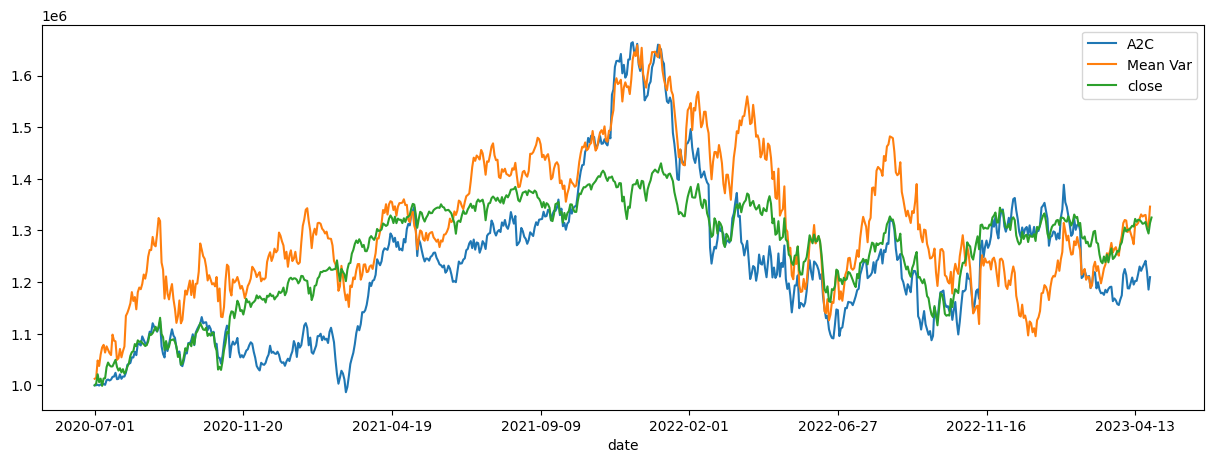

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

In the above results the A2C agent was able to outperform the market near the market peak.
<BR>
(it should be noted that the above are the exact same results as those obtained with the 3 part/pieces of code)